### Steps for CNN of ASL Dataset

Load ASL training and test datasets 
- don't know how to process the image from individual pixels to torch or matplotlib

Define a Convolutional Neural Network
- working on understand different parts of torch architecture steps

Define a loss function

Train the network on the training data

Test the network on the test data

Visualize # of each letter in datasets(Bar graph to show samples in each class)

Randomly generate 1 sample from each class

Show correctly classified and wrongly classified to show why some are easier to classify vs harder to classify

#### Dataset Origin 
https://www.kaggle.com/datamunge/sign-language-mnist

#### Pytorch tutorial/inspiration
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
#read in data
df_test = pd.read_csv('./sign_mnist_test.csv')
df_train = pd.read_csv('./sign_mnist_train.csv')

In [3]:
df_train.head()
df_test.head()
print(df_train.shape)
print(df_test.shape)

(27455, 785)
(7172, 785)


In [4]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
#separate labels (letter classes) from training data set
#drop label from rest of pixels
labels_train = df_train['label']
df_train = df_train.drop('label',axis = 1)

In [6]:
# #separate labels (letter classes) from test data set
#drop label from rest of pixels
labels_test = df_test['label']
df_test = df_test.drop('label',axis = 1)

### Data visualizations 
- visualize # of each letter in total dataset
- (randomly) generate sample
- more?

In [7]:
# create dataframe with all labels to make a bargraph
frames = [labels_train,labels_test]
df_all_labels = pd.concat(frames)
print(df_all_labels.shape)
df_all_labels.head()

(34627,)


0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64

[Text(0, 0.5, '# counts'), Text(0.5, 0, 'Alphabet Letters')]

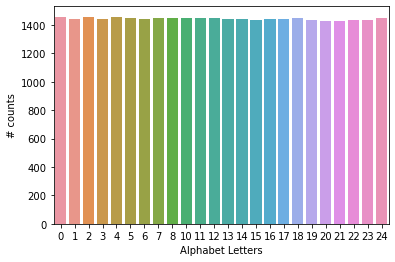

In [8]:
# create a bar graph with number of each labels
'''Want to change so that 0,1,2,3 etc reads A,B,C,D etc'''

ax = sns.barplot(x=df_all_labels.value_counts().index, y=df_all_labels.value_counts())
ax.set(ylabel = '# counts', xlabel = 'Alphabet Letters' )

In [9]:
df_all_labels.value_counts()

0     1457
4     1455
2     1454
5     1451
11    1450
8     1450
24    1450
12    1449
7     1449
18    1445
10    1445
16    1443
1     1442
14    1442
13    1442
3     1441
6     1438
17    1438
15    1435
19    1434
23    1431
22    1431
21    1428
20    1427
Name: label, dtype: int64

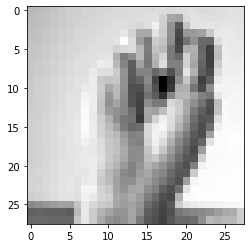

In [10]:
#convert each image to a 28x28 array
testimg = np.array(df_train[4:5]).reshape(28,28)
plt.imshow(testimg,cmap = 'gray')

### Converting data to tensor

In [11]:
# convert pandas df to numpy array and reshape into 28x28 array as prep for picture
''' only relevant for following cell with random image display'''

np_train = df_train.to_numpy() #training dataset
np_train = np_train.reshape(np_train.shape[0],28,28)
np_test = df_test.to_numpy() # testing dataset
np_test = np_test.reshape(np_test.shape[0],28,28)

Text(0.5, 0, '1')

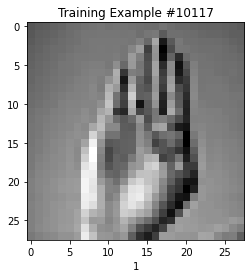

In [24]:
#show random image
random_image = random.randint(0,len(np_train))
plt.imshow(np_train[random_image], cmap = 'gray')
plt.title(f"Training Example #{random_image}")
plt.xlabel(labels_train[random_image]) #xlabel = letter of alphabet

In [14]:
#converting to tensor with dataloader
batch_size = 10

train = data_utils.TensorDataset(torch.Tensor(np.array(df_train).reshape(-1,28,28)), torch.Tensor(np.array(labels_train)))
test = data_utils.TensorDataset(torch.Tensor(np.array(df_test).reshape(-1,28,28)), torch.Tensor(np.array(labels_test)))

trainloader = DataLoader(train, batch_size = batch_size,
                         shuffle = True, num_workers = 2)
testloader = DataLoader(test, batch_size = batch_size,
                       shuffle = False, num_workers = 2)

In [15]:
#COME BACK LATER
'''https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html'''
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels_train[j] for j in range(batch_size)))

    3     6     2     2    13    16     8    22     3     3


In [16]:
#define neural network
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 1 input channel (gray), 6 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 24)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [29]:
# architecture from https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
class Net2(nn.Module):
    
    def __init__(self):
        super().__init__()
        #first 2d convolution layer 1 input, ouput 28 features, kernel 3x3
        self.conv1 = nn.Conv2d(1,32,3,1)
        #second conv layer, take in 28 layers, output 64 features, kernel 3x3
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 24)
    
    #x = data
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output
net2 = Net2()

In [17]:
#define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
# train network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        print(data)
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[tensor([[[176., 176., 177.,  ..., 159., 156., 158.],
         [181., 181., 181.,  ..., 161., 164., 148.],
         [185., 186., 186.,  ..., 164., 120.,  70.],
         ...,
         [155., 158., 161.,  ...,  91., 166., 160.],
         [131., 130., 130.,  ...,  71., 117., 167.],
         [137., 138., 139.,  ...,  73.,  72., 122.]],

        [[175., 180., 186.,  ..., 199., 199., 199.],
         [176., 181., 186.,  ..., 202., 201., 201.],
         [178., 183., 188.,  ..., 204., 203., 202.],
         ...,
         [150., 151., 148.,  ..., 140., 138., 137.],
         [154., 154., 152.,  ..., 141., 141., 140.],
         [155., 154., 153.,  ..., 146., 149., 140.]],

        [[141., 143., 144.,  ..., 140., 138., 138.],
         [144., 145., 145.,  ..., 144., 143., 142.],
         [146., 149., 150.,  ..., 148., 146., 145.],
         ...,
         [172., 175., 178.,  ..., 184., 183., 179.],
         [ 87.,  90.,  92.,  ..., 174., 168., 175.],
         [ 69.,  70.,  71.,  ..., 108., 128., 139.]]

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 1, 3, 3], but got 3-dimensional input of size [10, 28, 28] instead

In [30]:
# train network (Net2)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        print(data)
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[tensor([[[195., 195., 195.,  ..., 184., 183., 181.],
         [198., 198., 197.,  ..., 185., 185., 184.],
         [201., 201., 201.,  ..., 188., 187., 186.],
         ...,
         [228., 229., 230.,  ..., 219., 217., 216.],
         [229., 229., 230.,  ..., 219., 219., 217.],
         [229., 229., 230.,  ..., 220., 219., 217.]],

        [[ 94., 106., 117.,  ..., 169., 169., 168.],
         [ 95., 107., 118.,  ..., 170., 170., 170.],
         [ 98., 109., 119.,  ..., 171., 171., 171.],
         ...,
         [123., 130., 138.,  ..., 196., 196., 195.],
         [123., 130., 142.,  ..., 196., 196., 196.],
         [123., 131., 152.,  ..., 196., 197., 197.]],

        [[191., 192., 193.,  ..., 192., 192., 191.],
         [194., 195., 195.,  ..., 195., 194., 195.],
         [198., 198., 198.,  ..., 196., 196., 196.],
         ...,
         [236., 236., 237.,  ..., 236., 236., 235.],
         [236., 237., 237.,  ..., 237., 236., 237.],
         [238., 238., 237.,  ..., 238., 237., 238.]]

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 3, 3], but got 3-dimensional input of size [10, 28, 28] instead

In [ ]:
len(labels_train.unique())

In [ ]:
# class ASLDataset(Dataset):
    
#     def __init__(self,X,y):
#         self.X = X # X = training images
#         self.y = y # y = labels
        
#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self,index):
#         image = self.X[index]
#         X = self.transform(image)
#         return X
    

In [ ]:
# image_size = 28
# transform = T.Compose([T.ToPILImage(),
#                       T.Resize(image_size),
#                       T.ToTensor()])

In [ ]:
# batch_size = 20
# transformed_dataset = ASLDataset(np_train,labels_train)
# train_dl = DataLoader(transformed_dataset,batch_size, shuffle = True,
#                      num_workers = 3)


In [ ]:
# def show_images(images, nmax=64):
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
# def show_batch(dl, nmax=64):
#     for images in dl:
#         show_images(images, nmax)
#         break

In [ ]:
# show_batch(train_dl)